# Deep fake detection Proof of concept

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm #progress meter
%matplotlib inline 
import cv2 
from PIL import Image

import torch # if neural networks
from torch import nn
import torch.nn.functional as F
import torchvision #cnn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms 
from torch import optim

torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data  and function exploration

In [2]:
#DATA_FOLDER = '../input/deepfake-detection-challenge'
DATA_FOLDER = 'data'
TRAIN_SAMPLE_FOLDER = 'train_part0'
TEST_FOLDER = 'test_videos'
print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")
train_df = pd.read_json(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, 'metadata.json'))
train_df = train_df.T
train_df.head(3)

Train samples: 1335
Test samples: 400


label  split        original
owxbbpjpch.mp4  FAKE  train  wynotylpnm.mp4
vpmyeepbep.mp4  REAL  train             NaN
fzvpbrzssi.mp4  REAL  train             NaN

In [3]:
test_df = pd.DataFrame(list(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER))), columns=['video'])
test_df.head(3)

video
0  hclsparpth.mp4
1  bcbqxhziqz.mp4
2  zmxeiipnqb.mp4

In [4]:
filename = os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER, train_df.index[1])
video_o = cv2.VideoCapture(filename)
video_l = int(video_o.get(cv2.CAP_PROP_FRAME_COUNT))
video_w= int(video_o.get(cv2.CAP_PROP_FRAME_WIDTH))
video_h= int(video_o.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(video_l,video_w,video_h)

300 1080 1920


In [5]:
success,frame = video_o.read()
frame.shape

(1920, 1080, 3)

# Proof of concept

In [6]:
!pip install facenet-pytorch

In [7]:
from facenet_pytorch import MTCNN, InceptionResnetV1

In [8]:
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, device=device).eval()
# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

In [9]:
nTrainDir = 'train_part0'
train_df = pd.read_json(os.path.join(DATA_FOLDER, nTrainDir, 'metadata.json'))
train_df = train_df.T
train_df_false = train_df [train_df.label == 'FAKE']
train_df_false.head()

label  split        original
owxbbpjpch.mp4  FAKE  train  wynotylpnm.mp4
htorvhbcae.mp4  FAKE  train  wclvkepakb.mp4
fckxaqjbxk.mp4  FAKE  train  vpmyeepbep.mp4
sphirandia.mp4  FAKE  train  jawgcggquk.mp4
vsmadeuczx.mp4  FAKE  train  qarqtkvgby.mp4

In [10]:
filename = os.path.join(DATA_FOLDER, nTrainDir, train_df_false.index[1])
filename_org = os.path.join(DATA_FOLDER, nTrainDir,train_df_false.original[1])
print(filename,filename_org)

data/train_part0/htorvhbcae.mp4 data/train_part0/wclvkepakb.mp4


In [11]:
def get_face (filename):
    torch.cuda.empty_cache()
    video_o = cv2.VideoCapture(filename)
    success = video_o.grab()
    success, frame = video_o.retrieve()
    if  success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        Face = mtcnn(frame) ##TODO addd success decision and also batch selection
    video_o.release()
    return Face[0]

In [12]:
face = get_face(filename)
print('fake image')
plt.imshow(face[-1])

fake image


orginal image


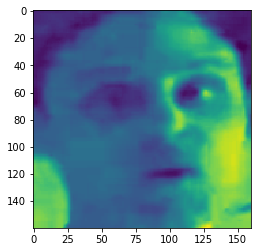

In [13]:
face_org = get_face(filename_org)
print('orginal image')
plt.imshow(face[-1])

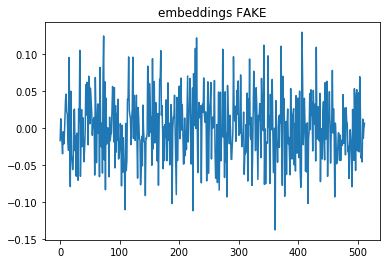

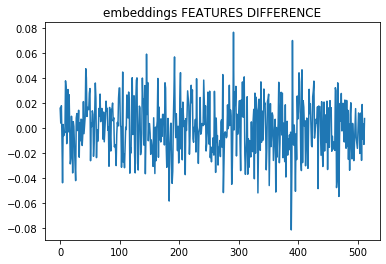

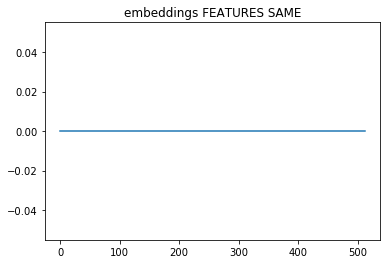

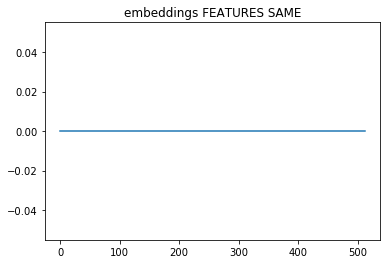

In [14]:
torch.cuda.empty_cache()
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()
embe = resnet(face[None].to(device))
data = embe.cpu().data.numpy()
data = data[0]
embe_org = resnet(face_org[None].to(device))
data_org = embe_org.cpu().data.numpy()
data_org = data_org[0]
fdf = data - data_org

plt.plot(data) # plotting by columns
plt.title('embeddings FAKE')
plt.show()
plt.plot(data_org) # plotting by columns
plt.title('embeddings ORIGINAL')
plt.show()
plt.plot(fdf) # plotting by columns
plt.title('embeddings FEATURES DIFFERENCE')
plt.show()
same = data-data
plt.plot(same) # plotting by columns
plt.title('embeddings FEATURES SAME')
plt.show()
same = data_org-data_org
plt.plot(same) # plotting by columns
plt.title('embeddings FEATURES SAME')
plt.show()

In [15]:
#iterate for each video 
torch.cuda.empty_cache()
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, device=device).eval()
def get_faces (filename, n_frames = 17):
    video_o = cv2.VideoCapture(filename)#get video 
    #get the lenght and divide inthe specified dataframes
    video_len = int(video_o.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_index_list = np.linspace(0, video_len - 1, n_frames).astype(int)
    face_batch = torch.tensor((),dtype = torch.float32)
    for frame_indx in range(video_len):
        if frame_indx in frame_index_list:
            success = video_o.grab()
            success, frame = video_o.retrieve()
            if  success: 
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                Face = mtcnn(frame) # succes will not be considered to train with noise data too
            else:
                Face = torch.tensor((),dtype = torch.float32)
                Face = Face.new_zeros([1, 3, 160, 160])
                
            if Face is None:
                Face = torch.tensor((),dtype = torch.float32)
                Face = Face.new_zeros([1, 3, 160, 160])
                
            face_batch = torch.cat((face_batch,Face))
            if len(face_batch) > n_frames:
                face_batch  = face_batch[:n_frames]
                
    video_o.release()
    return face_batch



In [16]:
#Normalization (Min-Max Scalar) :
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval() 
torch.cuda.empty_cache()
def get_fdfs(face_fake,face_original):
    '''return a tensor with the differneces feature'''
    f_fake = resnet(face_fake.to(device))
    f_original = resnet(face_original.to(device))
    f_diff = f_fake -f_original
    f_min = torch.min(f_diff)
    f_max = torch.max(f_diff)
    f_diff = ( f_diff - f_min)/(f_max-f_min)
    return f_diff

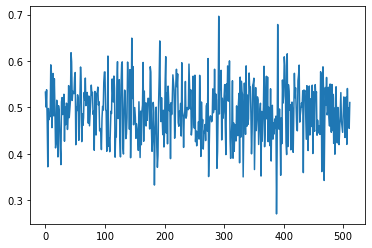

In [17]:

#test 
filename = os.path.join(DATA_FOLDER, nTrainDir, train_df_false.index[1])
filename_org = os.path.join(DATA_FOLDER, nTrainDir,train_df_false.original[1])
faces = get_faces(filename,n_frames =17)
faces_org = get_faces(filename_org,n_frames =17)
r= get_fdfs(faces,faces_org)
r.detach_()
r.shape
#test
plt.plot(r[0].cpu().data.numpy()) # plotting by columns
plt.show()

In [18]:
#define the Fdf CNN extractor we will use the same model as inception with initialized weights
fdf_model = InceptionResnetV1(pretrained='vggface2', device=device).train()
#fdf_model = InceptionResnetV1(pretrained='vggface2', device=device).train()
#loss is L2 loss
criterion_l2 = nn.MSELoss()
fdf_adam = optim.Adam(fdf_model.parameters(), lr=0.01)

In [19]:
def get_fdf(face_fake,face_original):
    '''return a tensor with the differneces feature'''
    f_fake = resnet(face_fake[None].to(device))
    f_original = resnet(face_org[None].to(device))
    f_diff = f_fake -f_original
    f_min = torch.min(f_diff)
    f_max = torch.max(f_diff)
    f_diff = ( f_diff - f_min)/(f_max-f_min)
    return f_diff
#return torch.sigmoid((f_fake - f_original)*100)

100%|██████████| 100/100 [00:10<00:00,  9.10it/s]

0.25016191601753235


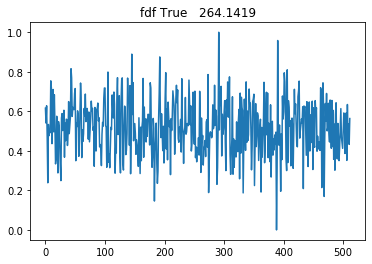

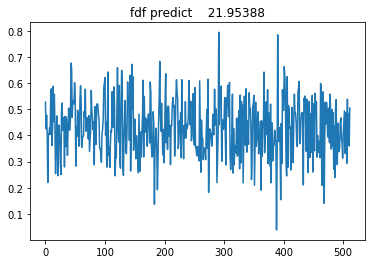

In [21]:
#now try to overfit the firt iterartion
#first get the original face and the fake face and get the embeddings , then rest and get the difference then train over 
torch.cuda.empty_cache()
filename = os.path.join(DATA_FOLDER, nTrainDir, train_df_false.index[1])
filename_org = os.path.join(DATA_FOLDER, nTrainDir,train_df_false.original[1])
face_fake = get_face(filename)
face_original = get_face(filename_org)
f_df = get_fdf(face_fake,face_original)
#now train our system, froma fake face we want to extract the difference vector
#to suppot batch normalization batch size has to be at least 2 managed 5 or 17 for memory consuption only a test
face_fake_b = torch.cat([face_fake[None],face_fake[None]])
face_original_b = torch.cat([face_original[None],face_original[None]])
f_df = torch.cat([f_df,f_df])
f_df.detach_()
#true_df =  = torch.tensor((),requires_grad = False,dtype = torch.float32)
#true_df = true_df.new_zeros(f_df.shape)
true_df = torch.randint_like(f_df,0,3,requires_grad = False,dtype = torch.float32)/10.0

nOverfitEpochs = 100
for indx in tqdm(range(nOverfitEpochs)):
    #train on fake
    fdf_adam.zero_grad()
    out_embedding = fdf_model(face_fake_b.to(device))
    loss_f = criterion_l2(out_embedding,f_df)
    loss_f.backward()
    #fdf_adam.step()
    #train on original
    if indx%2 == 0:
        #fdf_adam.zero_grad()
        out_embedding_o = fdf_model(face_original_b.to(device))
        loss_o = criterion_l2(out_embedding_o,true_df.to(device))
        loss_o.backward()
        loss_o = loss_o +loss_f
    fdf_adam.step()
    
    
print(loss_o.item())
eval_vector = out_embedding[0]-f_df[0] 
plt.plot(f_df[0].cpu().data.numpy()) # plotting by columns
plt.title('fdf True   ' + str(f_df[0].cpu().data.numpy().sum()))
plt.show()
plt.plot(out_embedding[0].cpu().data.numpy()*10) # plotting by columns
plt.title('fdf predict    ' + str(out_embedding[0].cpu().data.numpy().sum()) )
plt.show()
plt.plot(eval_vector.cpu().data.numpy()) # plotting by columns
plt.title('fdf diff    ' + str(eval_vector.cpu().data.numpy().sum()) )
plt.show()

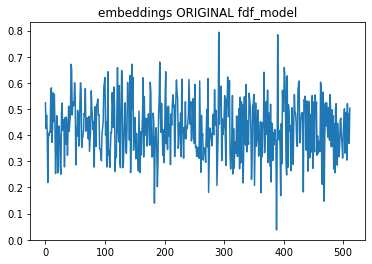

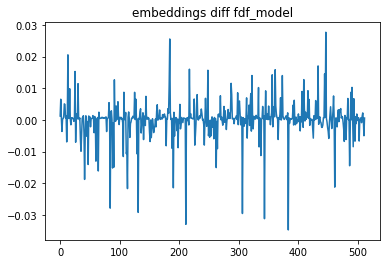

In [22]:
#get the embedding for the fake and the true face
fdf_model.eval()
f_fake = fdf_model(face_fake[None].to(device))
f_original = fdf_model(face_original[None].to(device))
plt.plot(f_fake[0].cpu().data.numpy()*10) # plotting by columns
plt.title('embeddings FAKE from fdf_model')
plt.show()
plt.plot(f_original[0].cpu().data.numpy()*10) # plotting by columns
plt.title('embeddings ORIGINAL fdf_model')
plt.show()
eval_diff = f_fake[0]*10-f_original[0] *10
plt.plot(eval_diff.cpu().data.numpy()) # plotting by columns
plt.title('embeddings diff fdf_model')
plt.show()

In [24]:
#Now define the model to output if fake or not 
class FakeClassifier(nn.Module):
    def __init__(self):
        super(FakeClassifier,self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.hidden1 = nn.Sequential(
            nn.Linear(256,128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.hidden2 = nn.Sequential(
            nn.Linear(128,64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.hidden3 = nn.Sequential(
            nn.Linear(64,32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3))
        self.out =  nn.Linear(32,1) #BCELoss
       # self.out =  nn.Linear(32,2) #CrossEntropyLoss
        
    def forward(self,x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.out(x)
        return x

In [25]:
fake_classifier = FakeClassifier()
classifier_adam_optim = optim.Adam(fake_classifier.parameters(),lr = 0.01)
criterion_BCE = nn.BCEWithLogitsLoss()
criterion_CEL = nn.CrossEntropyLoss()

In [26]:
#first get the embeddigns 
#get the embedding for the fake and the true face
fdf_model.eval()
f_fake = fdf_model(face_fake[None].to(device))
f_original = fdf_model(face_original[None].to(device))
f_fake.detach_()
f_original.detach_()
#then overfit the classifier
torch.cuda.empty_cache()
fake_classifier.to(device)
fake_classifier.train()
#fake_tensor = torch.tensor([1],requires_grad = False)
#true_tensor = torch.tensor([0],requires_grad = False)
#true_tensor = torch.tensor([0.0],requires_grad = False)
nOverfitEpochs = 100
for indx in tqdm(range(nOverfitEpochs)):
   
    fake_tensor = torch.randint(7,12,(1,1),requires_grad = False,dtype = torch.float32)/10.0
    fake_tensor =fake_tensor[0]
    true_tensor = torch.randint(0,3,(1,1),requires_grad = False,dtype = torch.float32)/10.0
    true_tensor = true_tensor[0]
    #train on fake
    classifier_adam_optim.zero_grad()
    out_class = fake_classifier(f_fake.to(device))
    #loss = criterion_CEL(out_class,fake_tensor.to(device))
    loss_f = criterion_BCE(out_class,fake_tensor[None].to(device))
    loss_f.backward()
   # classifier_adam_optim.step()
    #classifier_adam_optim.zero_grad()
    if indx%2 == 0:
        out_class_o = fake_classifier(f_original.to(device))
        #loss = criterion_CEL(out_class_o,true_tensor.to(device))
        loss_o = criterion_BCE(out_class_o,true_tensor[None].to(device)) 
        loss_o.backward()
        loss_o = loss_o + loss_f
    classifier_adam_optim.step()
    
print(loss_o.item())
print(torch.sigmoid(out_class))
#print(out_class)


100%|██████████| 100/100 [00:00<00:00, 327.83it/s]

1.4930658340454102
tensor([[0.6961]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [27]:
fake_classifier.eval()
print('prediction on fake  ',torch.sigmoid(fake_classifier(f_fake.to(device)) ) )
print('prediction on original  ',torch.sigmoid(fake_classifier(f_original.to(device)) ) )

prediction on fake   tensor([[0.6866]], device='cuda:0', grad_fn=<SigmoidBackward>)
prediction on original   tensor([[0.6865]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [ ]:
#iterate for each video in a folder
def train_fdf_model():
    torch.cuda.empty_cache()
    fdf_model.train()
    true_df = torch.tensor((),requires_grad = False,dtype = torch.float32)
    for train_folder in naTrainFolder:
        #create a df for each train folder in order to use train_test_split
        train_df = pd.read_json(os.path.join(nDataFolder, naTrainFolder[0], 'metadata.json'))
        train_df = train_df.T
        train_df_false = train_df [train_df.label == 'FAKE']
        train_videos,train_y,eval_videos,eval_y = train_test_split(train_df_false,train_df_false.label,train_size = 0.8,random_state =3)     

        for video_name,video in tqdm(train_videos.iterrows()):
            #access the video 
            filename = os.path.join(nDataFolder, naTrainFolder[0], video_name)
            filename_org = os.path.join(nDataFolder, naTrainFolder[0],video.original)
            #get the batched faces 
            face_fakes = get_faces(filename,n_frames =17)
            face_originals = get_faces(filename_org,n_frames =17)
            #get the difference vector
            f_df = get_fdf(face_fakes,face_originals)
            f_df.detach_()
            #create the true vector
            true_df = true_df.new_zeros(f_df.shape)
            #Train on fake
            fdf_adam.zero_grad()
            out_embedding = fdf_model(face_fakes.to(device))
            loss = criterion_l2(out_embedding,f_df)
            loss.backward()
            fdf_adam.step()
            #train on original
            fdf_adam.zero_grad()
            out_embedding_o = fdf_model(face_originals.to(device))
            loss = criterion_l2(out_embedding_o,true_df.to(device))
            loss.backward()
            fdf_adam.step()   
        print('loss',loss.item())

   #iterate for each video 
def train_classifier():
    torch.cuda.empty_cache()
    fdf_model.eval()
    fake_classifier.train()
    fake_tensor = torch.tensor((),requires_grad = False,dtype = torch.float32)
    true_tensor = torch.tensor((),requires_grad = False,dtype = torch.float32)
    #fake_tensor = torch.tensor([1.0],requires_grad = False)
    #true_tensor = torch.tensor([0.0],requires_grad = False)
    for train_folder in naTrainFolder:
        #create a df for each train folder in order to use train_test_split
        train_df = pd.read_json(os.path.join(nDataFolder, naTrainFolder[0], 'metadata.json'))
        train_df = train_df.T
        train_df_false = train_df [train_df.label == 'FAKE']
        train_videos,train_y,eval_videos,eval_y = train_test_split(train_df_false,train_df_false.label,train_size = 0.8,random_state =3)     

        for video_name,video in tqdm(train_videos.iterrows()):
            #access the video 
            
            filename = os.path.join(nDataFolder, naTrainFolder[0], video_name)
            filename_org = os.path.join(nDataFolder, naTrainFolder[0],video.original)
            #get the batched faces 
            #get the batched faces 
            face_fakes = get_faces(filename,n_frames =17)
            face_originals = get_faces(filename_org,n_frames =17)

            #get the differences vector
            f_fakes = fdf_model(face_fakes.to(device))
            f_originals = fdf_model(face_originals.to(device))
            f_fakes.detach_()
            f_originals.detach_()

            #start train


            fake_classifier.zero_grad()
            out_class = fake_classifier(f_fakes.to(device))
            #create fake vector
            fake_tensor = fake_tensor.new_ones(out_class.shape)
            #loss = criterion_CEL(out_class,fake_tensor.to(device))
            loss = criterion_BCE(out_class,fake_tensor.to(device))
            loss.backward()
            classifier_adam_optim.step()
            #train on true
            fake_classifier.zero_grad()
            out_class_o = fake_classifier(f_originals.to(device))
            #create true tensor
            true_tensor = true_tensor.new_zeros(out_class_o.shape)
            #loss = criterion_CEL(out_class_o,true_tensor.to(device))
            loss = criterion_BCE(out_class_o,true_tensor.to(device))
            loss.backward()
            classifier_adam_optim.step()
        print('loss',loss.item())
        #print(torch.sigmoid(out_class))

In [ ]:
#iterate for each video in a folder
def train_fdf_model():
    torch.cuda.empty_cache()
    fdf_model.train()
    true_df = torch.tensor((),requires_grad = False,dtype = torch.float32)
    for video_name,video in tqdm(train_videos.iterrows()):
        #access the video 
        filename = os.path.join(nDataFolder, naTrainFolder[0], video_name)
        filename_org = os.path.join(nDataFolder, naTrainFolder[0],video.original)
        #get the batched faces 
        face_fakes = get_faces(filename,n_frames =17)
        face_originals = get_faces(filename_org,n_frames =17)
        #get the difference vector
        f_df = get_fdf(face_fakes,face_originals)
        f_df.detach_()
        #create the true vector
        true_df = true_df.new_zeros(f_df.shape)
        #Train on fake
        fdf_adam.zero_grad()
        out_embedding = fdf_model(face_fakes.to(device))
        loss = criterion_l2(out_embedding,f_df)
        loss.backward()
        fdf_adam.step()
        #train on original
        fdf_adam.zero_grad()
        out_embedding_o = fdf_model(face_originals.to(device))
        loss = criterion_l2(out_embedding_o,true_df.to(device))
        loss.backward()
        fdf_adam.step()   
    print('loss',loss.item())
    
#iterate for each video 
def train_classifier():
    torch.cuda.empty_cache()
    fdf_model.eval()
    fake_classifier.train()
    fake_tensor = torch.tensor((),requires_grad = False,dtype = torch.float32)
    true_tensor = torch.tensor((),requires_grad = False,dtype = torch.float32)
    #fake_tensor = torch.tensor([1.0],requires_grad = False)
    #true_tensor = torch.tensor([0.0],requires_grad = False)
    for video_name,video in tqdm(train_videos.iterrows()):
        #access the video 
        filename = os.path.join(nDataFolder, naTrainFolder[0], video_name)
        filename_org = os.path.join(nDataFolder, naTrainFolder[0],video.original)
        #get the batched faces 
        #get the batched faces 
        face_fakes = get_faces(filename,n_frames =17)
        face_originals = get_faces(filename_org,n_frames =17)

        #get the differences vector
        f_fakes = fdf_model(face_fakes.to(device))
        f_originals = fdf_model(face_originals.to(device))
        f_fakes.detach_()
        f_originals.detach_()

        #start train


        classifier_adam_optim.zero_grad()
        out_class = fake_classifier(f_fakes.to(device))
        #create fake vector
        fake_tensor = fake_tensor.new_ones(out_class.shape)
        #loss = criterion_CEL(out_class,fake_tensor.to(device))
        loss = criterion_BCE(out_class,fake_tensor.to(device))
        loss.backward()
        classifier_adam_optim.step()
        #train on true
        classifier_adam_optim.zero_grad()
        out_class_o = fake_classifier(f_originals.to(device))
        #create true tensor
        true_tensor = true_tensor.new_zeros(out_class_o.shape)
        #loss = criterion_CEL(out_class_o,true_tensor.to(device))
        loss = criterion_BCE(out_class_o,true_tensor.to(device))
        loss.backward()
        classifier_adam_optim.step()
    print('loss',loss.item())
    #print(torch.sigmoid(out_class))